16384000
256
256
8000
results with features=  256 , kernel_initializer =  he_normal , learn_rate(ADAM) =  0.001 , batch_size =  4
Epoch 1/2
1600/1600 [==============================] - 1s 732us/step - loss: 1.4238 - categorical_accuracy: 0.2532 - val_loss: 1.3551 - val_categorical_accuracy: 0.3225
Epoch 2/2
1600/1600 [==============================] - 1s 689us/step - loss: 1.3528 - categorical_accuracy: 0.3549 - val_loss: 1.3284 - val_categorical_accuracy: 0.6938
loss: 1.3459407091140747 , categorical_accuracy: 0.3778125047683716 , val_loss: 1.3284475803375244 , val_categorical_accuracy: 0.6937500238418579


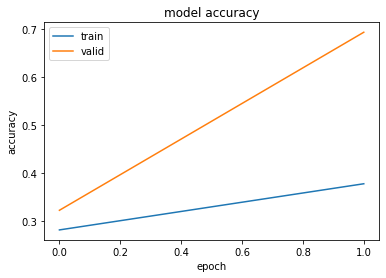

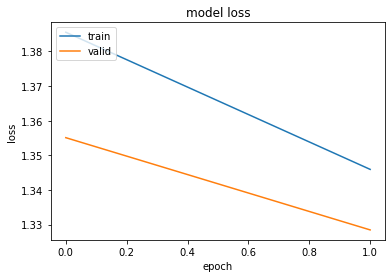

results with features=  256 , kernel_initializer =  he_normal , learn_rate(ADAM) =  0.001 , batch_size =  4
Epoch 1/2
1544/1600 [===========================>..] - ETA: 0s - loss: 1.4247 - categorical_accuracy: 0.2555

KeyboardInterrupt: 

In [7]:
import struct
import numpy as np
import tensorflow as tf
from random import shuffle
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import layers, initializers, regularizers, optimizers, callbacks
from PIL import Image
import matplotlib
import matplotlib.cm as cm
from scipy.special import softmax

def load_samples(shuffle_samples):

    hash_size = 0
    with open('params.binary', "rb") as f:
        data = f.read()
        hash_size = int(data[0])**2
    
    X = []
    Y = []
    nb_samples = 0
    with open('X.binary', "rb") as f:
        data = f.read()
        print(len(data))
        print(hash_size)
        nb_samples = len(data)//(hash_size*8)
        for i in range(nb_samples):
            tmp = [0.0 for i in range(hash_size)]
            buff = data[(i*hash_size)*8:(i+1)*hash_size*8]
            for j in range(hash_size):
                    tmp[j] = struct.unpack('d', buff[j*8:(j+1)*8])[0]
            X += [tmp]

    with open('Y.binary', "rb") as f:
        data = f.read()
        for i in data:
            tmp = [0, 0, 0, 0]
            tmp[int(i)] = 1
            Y += [tmp]

    if shuffle_samples:
        available = [i for i in range(nb_samples)]
        shuffle(available)
        X_shuffled = []
        Y_shuffled = []    
        for i in available:
            X_shuffled += [X[i]]
            Y_shuffled += [Y[i]]
        return np.array(X_shuffled), np.array(Y_shuffled)
    else:
        return np.array(X), np.array(Y)

def evaluate_model(k):
    
    #paste the model found by grid search to evaluate on different splits

    X_suffled, Y_suffled = load_samples(True)

    nb_samples = len(X_suffled)

    features = len(X_suffled[0])

    split = nb_samples//k
    print(nb_samples)
    print(split)

    for i in range(k):
        print("k : {}/{}".format(i+1,k))

        x_train = np.concatenate((X_suffled[:nb_samples-split*(i+1)], X_suffled[nb_samples-split*i:]), axis=0)
        y_train = np.concatenate((Y_suffled[:nb_samples-split*(i+1)], Y_suffled[nb_samples-split*i:]), axis=0)
        x_val = np.array(X_suffled[nb_samples-split*(i+1):nb_samples-split*i])
        y_val = np.array(Y_suffled[nb_samples-split*(i+1):nb_samples-split*i])
        print('Training on , ', len(x_train), 'samples')
        print('Validating on , ', len(x_val), 'samples')
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(4, activation='softmax', kernel_initializer='he_normal', input_shape=(features,)))
        model.compile(optimizer=optimizers.Adam(learning_rate=0.01),
                        loss='categorical_crossentropy',
                        metrics='categorical_accuracy')
        history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=8, verbose=1)

        for i in history.history.keys():
            print(i, history.history[i][-1])
        print()

def final_model():

    #Load the training data
    X, Y = load_samples(True)

    nb_samples = len(X)
    features = len(X[0])
    #final params
    ki = 'he_normal'
    lr = 0.01
    bs = 4
    #regularizers
    l1=1e-8
    l2=1e-8
    #early stopping
    callback = callbacks.EarlyStopping(monitor='loss', patience=10, min_delta=0.01)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(4, activation='softmax', kernel_initializer=ki, input_shape=(features,),kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics='categorical_accuracy')

    print("results with featuers= ",features,", kernel_initializer = ", ki, ", learn_rate(ADAM) = ", lr, ", batch_size = ", bs )

    history = model.fit(X, Y, epochs=400, batch_size=bs, verbose=1, validation_split=0.2, callbacks=[callback])

    predictions = model.predict(X, verbose=2)

    for i in range(len(model.layers)):
        layer = model.layers[i]
        #print(layer.get_config())
        weights = layer.get_weights()

        norm = matplotlib.colors.Normalize(vmin=np.min(weights[0]), vmax=np.max(weights[0]), clip=True)
        mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)


#         scaley = 80
#         scalex = 8
#         array = []
#         for j in range(len(weights[0].T)):
#             w = weights[0].T[j]
#             for k in range(scaley):
#                 tmp0 = []
#                 for xx in w:
#                     for u in range(scalex):
#                         tmp0 += [[round(i*255) for i in mapper.to_rgba(xx)]]

#                 array += [tmp0]
        
#         array = np.array(array, dtype=np.uint8)
#         new_image = Image.fromarray(array)
#         new_image.save('weights_layer_{}.png'.format(i))

        #Save both bias and weights in bianry and npy format
        data = []
        flattened_weights = weights[0].flatten()
        for j in range(len(flattened_weights)):
            data += struct.pack('d', flattened_weights[j])

        with open("weights_layer_{}".format(i), "wb") as f:
            f.write(bytearray(data))
            f.close()
        np.save('weights_layer_{}.npy'.format(i), weights[0])
        
        data = []
        flattened_bias = weights[1].flatten()
        for j in range(len(flattened_bias)):
            data += struct.pack('d', flattened_bias[j])

        with open("bias_layer_{}".format(i), "wb") as f:
            f.write(bytearray(data))
            f.close()
        np.save('bias_layer_{}.npy'.format(i), weights[1])
def train_model_grid_search():
    #grids
    
    kernel_initializers = ['he_normal','random_normal', 'glorot_normal']
    learn_rate = [0.001,0.005, 0.01,0.05,0.1]
    batch_sizes = [4,8,16,32,64,128]
    l1g=[1e-7, 1e-8]
    l2g=[1e-7, 1e-8]
    nb_epochs=200
    #Load the training data
    X, Y = load_samples(True)

    nb_samples = len(X)
    features = len(X[0])
    print(features)
    print(nb_samples)
    #grid search
    callback = callbacks.EarlyStopping(monitor='loss', patience=20)
    for ki in kernel_initializers:
        for lr in learn_rate:
            for bs in batch_sizes:
                for l1 in l1g:
                    for l2 in l2g:
                        model = tf.keras.Sequential()
                        model.add(tf.keras.layers.Dense(4, activation='softmax', kernel_initializer=ki, input_shape=(features,),kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
                        model.compile(
                            optimizer=optimizers.Adam(learning_rate=lr),
                            loss='categorical_crossentropy',
                            metrics='categorical_accuracy')

                        print("results with features= ",features,", kernel_initializer = ", ki, ", learn_rate(ADAM) = ", lr, ", batch_size = ", bs )

                        history = model.fit(X, Y, epochs=nb_epochs, batch_size=bs, verbose=1, validation_split=0.2, callbacks=[callback])

                        print("loss:",history.history['loss'][nb_epochs-1], 
                              ", categorical_accuracy:",history.history['categorical_accuracy'][nb_epochs-1],
                              ", val_loss:",history.history['val_loss'][nb_epochs-1],
                              ", val_categorical_accuracy:",history.history['val_categorical_accuracy'][nb_epochs-1])
    #                    predictions = model.predict(X, verbose=2)

                        # summarize history for accuracy
                        plt.plot(history.history['categorical_accuracy'])
                        plt.plot(history.history['val_categorical_accuracy'])
                        plt.title('model accuracy')
                        plt.ylabel('accuracy')
                        plt.xlabel('epoch')
                        plt.legend(['train', 'valid'], loc='upper left')
                        plt.show()
                        # summarize history for loss
                        plt.plot(history.history['loss'])
                        plt.plot(history.history['val_loss'])
                        plt.title('model loss')
                        plt.ylabel('loss')
                        plt.xlabel('epoch')
                        plt.legend(['train', 'valid'], loc='upper left')
                        plt.show()

def test_model():
    from random import random
    
    X, Y = load_samples(False)

    weights = np.load('weights_layer_0.npy')
    bias = np.load('bias_layer_0.npy')

    err = 0
    minmaxL = 10
    minL = 0
    maxL = 0

    for i in range(len(X)):
        L = np.matmul(X[i], weights) + bias

        minL = min(minL, np.min(L))
        maxL = max(maxL, np.max(L))

        idx = L.tolist().index(np.max(L))

        minmaxL = min(minmaxL, L[idx])

        if idx != Y[i].tolist().index(1):
            err += 1

    print(err)
    print(minmaxL)
    print("minL", minL)
    print("maxL", maxL)

if __name__ == "__main__":
#     final_model()
    train_model_grid_search()
#     evaluate_model(k=2)
    #test_model()
